In [1]:
import os
import random
from collections import Counter
from datetime import datetime

import pandas as pd
from matplotlib import pyplot as plt, font_manager, rcParams

# Aksara font
FONT_PATH = "./fonts/Noto_Sans_Javanese/static/NotoSansJavanese-Regular.ttf"
font_manager.fontManager.addfont(FONT_PATH)
rcParams["font.family"] = font_manager.FontProperties(fname=FONT_PATH).get_name()

In [2]:
TOTAL_SAMPLE = 1000
CSV_PATH = (
    "./data/word_nglegena_pasangan_sandangan_"
    f"{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    "/label.csv"
)

CONFIG = {
    "min_word": 2,
    "max_word": 6,

    "cluster_prob": 0.35,   # Pasangan (gugus konsonan)
    "pangkon_prob": 0.20,   # Pangkon yang hanya di akhir kata
    "panyigeg_prob": 0.15,
    "sandangan_prob": 0.55,
}

coverage = {
    "nglegena": Counter(),
    "pasangan": Counter(),  # Pasangan (gugus konsonan)
    "pangkon": Counter(),   # Pangkon yang hanya di akhir kata
    "panyigeg": Counter(),
    "sandangan": Counter(),
}


In [3]:
# Huruf Dasar (Aksara Nglegena) [20]
NGLEGENA = [
    ("ꦲ","ha"), ("ꦤ","na"), ("ꦕ","ca"), ("ꦫ","ra"), ("ꦏ","ka"),
    ("ꦢ","da"), ("ꦠ","ta"), ("ꦱ","sa"), ("ꦮ","wa"), ("ꦭ","la"),
    ("ꦥ","pa"), ("ꦝ","dha"), ("ꦗ","ja"), ("ꦪ","ya"), ("ꦚ","nya"),
    ("ꦩ","ma"), ("ꦒ","ga"), ("ꦧ","ba"), ("ꦛ","tha"), ("ꦔ","nga"),
]

# Huruf Pasangan (Aksara Pasangan) [20]
# - Pasangan hanya boleh muncul setelah aksara lain
# - Satu Aksara Hanya Bisa “Menampung” satu pasangan
# Pangkon + Huruf Dasar = Aksara Pasangan (Ex:  ꧀ + ꦲ =  ꧀ꦲ)
PASANGAN = {
    aks: "꧀" + aks
    for aks, _ in NGLEGENA
}

# Pangkon (Penghilang bunyi vokal bawaan) [1]
# - Harus berada di akhir kata/suku kata
# - Tidak boleh jika Konsonan mati diikuti konsonan lain dalam satu gugus atau ada pasangan yang dapat digunakan
PANGKON = ("꧀","")

# Panyigeg Wanda (Menghentikan vokal & menambahkan konsonan penutup/bunyi akhir) [3]
# - Selalu di akhir suku kata
# - Tidak boleh diikuti pasangan
PANYIGEG = [
    ("ꦂ","r"),   # Layar
    ("ꦃ","h"),   # Wignyan
    ("ꦁ","ng"),   # Cecak
]

# Sandhangan Swara (Vokal tidak mandiri) [5]
# - Tidak boleh menumpuk dua sandangan swara pada satu aksara (kecuali kombinasi /o/ Taling tarung)
# - Tidak boleh jika aksara sudah dimatikan (pangkon / panyigeg) atau aksara diikuti pasangan yang mematikan vokalnya
SANDANGAN = [
    ("ꦶ","i"),   # Wulu
    ("ꦸ","u"),   # Suku
    ("ꦺ","é"),   # Taling
    ("ꦼ","ê"),   # Pepet
    ("ꦴ","o"),   # Taling Tarung
]


# ================================
# Tidak Termasuk
# ================================

# Aksara Swara (Huruf Vokal Mandiri)
# SWARA = [
#     ("ꦄ","a"), ("ꦆ","i"), ("ꦈ","u"), ("ꦌ","e"), ("ꦎ","o")
# ]

# Aksara Murda (Hampir setara dengan huruf kapital)
# AKSARA_MURDA = [
#     ("ꦟ", "Na Murda"), ("ꦑ", "Ka Murda"), ("ꦡ", "Ta Murda"), ("ꦯ", "Sa Murda"), 
#     ("ꦦ", "Pa Murda"), ("ꦘ", "Nya Murda"), ("ꦓ", "Ga Murda"), ("ꦨ", "Ba Murda")
# ]

# Aksara Rekan (Digunakan untuk kata serapan khususnya dari Arab)
# AKSARA_REKAN = [
#     ("ꦒ꦳", "gha"), ("ꦥ꦳", "fa/va"), ("ꦏ꦳", "kha"), ("ꦢ꦳", "dza"), ("ꦗ꦳", "za")
# ]

# Untuk menuliskan angka
# ANGKA_JAWA = [
#     ("꧐", "0"), ("꧑", "1"), ("꧒", "2"), ("꧓", "3"), ("꧔", "4"), 
#     ("꧕", "5"),  ("꧖", "6"), ("꧗", "7"), ("꧘", "8"), ("꧙", "9")
# ]

# Tanda Baca 
# TANDA_BACA_JAWA = [
#     ("꧈", "pada_lingsa"), ("꧉", "pada_lungsi"), ("꧊", "adeg_adeg"), ("꧇", "rerenggan"),
#     ("꧌", "tanda_kutip_buka"), ("꧍", "tanda_kutip_tutup"), ("꧁", "tanda_awal"), ("꧂", "tanda_akhir")
# ]


In [4]:
def generate_syllable(cfg, coverage):
    """
    Menghasilkan satu suku kata Aksara Jawa (tanpa panyigeg).

    Alur state:
        START
        → LIVE_CONSONANT
        → OPTIONAL_SANDHANGAN
        → OPTIONAL_CLUSTER

    Catatan ortografi:
    - Tidak pernah menghasilkan panyigeg.
    - Tidak pernah menghasilkan pangkon.
    """

    jawa, latin = "", ""

    # START → LIVE_CONSONANT
    aks, lat = random.choice(NGLEGENA)
    jawa += aks
    latin += lat
    coverage["nglegena"][aks] += 1

    # OPTIONAL_SANDHANGAN
    if random.random() < cfg["sandangan_prob"]:
        s, s_lat = random.choice(SANDANGAN)
        jawa += s
        latin = latin[:-1] + s_lat
        coverage["sandangan"][s] += 1

    # OPTIONAL_CLUSTER
    if random.random() < cfg["cluster_prob"]:
        aks2, lat2 = random.choice(NGLEGENA)

        jawa += PASANGAN[aks2]
        latin = latin[:-1]
        coverage["pasangan"][aks2] += 1

        jawa += aks2
        latin += lat2
        coverage["nglegena"][aks2] += 1

    return jawa, latin


def generate_word(cfg, coverage):
    """
    Menghasilkan satu kata Aksara Jawa yang sah secara ortografi.

    Aturan keras:
    - Panyigeg hanya boleh di akhir kata.
    - Pangkon hanya boleh di akhir kata.
    - Tidak ada pasangan setelah panyigeg.
    """

    length = random.randint(cfg["min_word"], cfg["max_word"])
    jawa, latin = "", ""

    for i in range(length):
        j, l = generate_syllable(cfg, coverage)
        jawa += j
        latin += l

    # OPTIONAL_PANYIGEG (hanya sekali, di akhir kata)
    if random.random() < cfg["panyigeg_prob"]:
        p, p_lat = random.choice(PANYIGEG)
        jawa += p
        latin += p_lat
        coverage["panyigeg"][p] += 1

    # OPTIONAL_PANGKON (juga hanya di akhir kata)
    if random.random() < cfg["pangkon_prob"]:
        jawa += PANGKON[0]
        coverage["pangkon"]["꧀"] += 1

    return jawa, latin, length


def generate_dataset(total):
    rows = []

    for i in range(total):
        jawa, latin, length = generate_word(CONFIG, coverage)
        rows.append({
            "image": f"img_{i:05d}.png",
            "transcription": jawa,
            "transliteration": latin,
            "length": length
        })

    return pd.DataFrame(rows), coverage

df, coverage = generate_dataset(TOTAL_SAMPLE)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)
df.to_csv(CSV_PATH, index=False, encoding="utf-8")

print("Total rows:", len(df))
print(df.count())
df.head()

Total rows: 1000
image              1000
transcription      1000
transliteration    1000
length             1000
dtype: int64


,image,transcription,transliteration,length
0,img_00000.png,ꦱꦶ꧀ꦔꦔꦪ,sngaya,2
1,img_00001.png,ꦗꦼꦭꦏꦼꦪꦺꦔ꧀ꦪꦪꦃ꧀,jêlakêyéngyah,5
2,img_00002.png,ꦱ꧀ꦪꦪꦚ꧀ꦱꦱꦠꦼꦪꦼ꧀ꦠꦠꦭ꧀ꦏꦏ,syanysatêytalka,5
3,img_00003.png,ꦝꦺꦪꦸꦪꦱꦏꦃ,dhéyuyasakah,5
4,img_00004.png,ꦧꦶ꧀ꦝꦝꦲꦼꦪꦴꦱ꧀ꦔꦔꦝꦸꦗꦸ,bdhahêyosngadhuju,6


NGLEGENA (AKSARA DASAR)
Total kemunculan : 5465
------------------------------------------------------------
  ꦲ (ha) |     285 |   5.22%
  ꦤ (na) |     260 |   4.76%
  ꦕ (ca) |     277 |   5.07%
  ꦫ (ra) |     260 |   4.76%
  ꦏ (ka) |     272 |   4.98%
  ꦢ (da) |     275 |   5.03%
  ꦠ (ta) |     281 |   5.14%
  ꦱ (sa) |     287 |   5.25%
  ꦮ (wa) |     279 |   5.11%
  ꦭ (la) |     279 |   5.11%
  ꦥ (pa) |     297 |   5.43%
  ꦝ (dha) |     279 |   5.11%
  ꦗ (ja) |     260 |   4.76%
  ꦪ (ya) |     290 |   5.31%
  ꦚ (nya) |     261 |   4.78%
  ꦩ (ma) |     239 |   4.37%
  ꦒ (ga) |     265 |   4.85%
  ꦧ (ba) |     308 |   5.64%
  ꦛ (tha) |     250 |   4.57%
  ꦔ (nga) |     261 |   4.78%



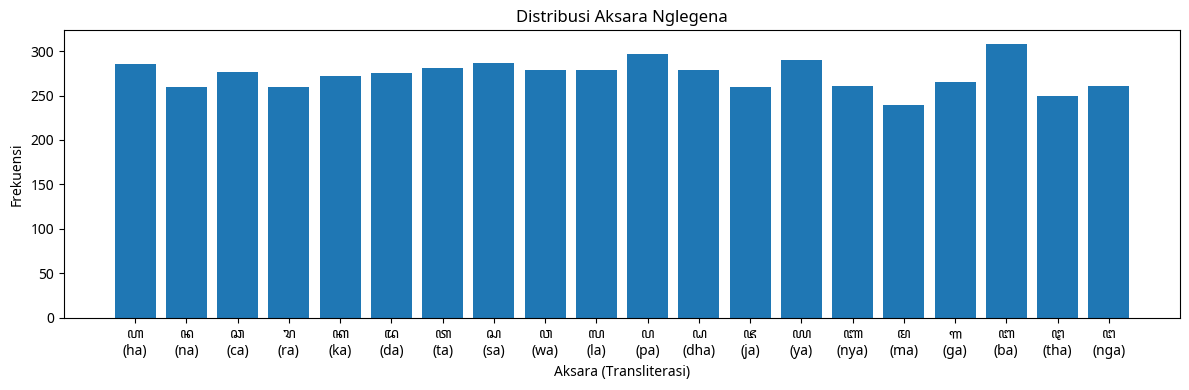

PASANGAN (GUGUS KONSONAN)
Total kemunculan : 1402
------------------------------------------------------------
  ꦲ (ha) |      82 |   5.85%
  ꦤ (na) |      66 |   4.71%
  ꦕ (ca) |      76 |   5.42%
  ꦫ (ra) |      69 |   4.92%
  ꦏ (ka) |      61 |   4.35%
  ꦢ (da) |      71 |   5.06%
  ꦠ (ta) |      83 |   5.92%
  ꦱ (sa) |      80 |   5.71%
  ꦮ (wa) |      67 |   4.78%
  ꦭ (la) |      66 |   4.71%
  ꦥ (pa) |      81 |   5.78%
  ꦝ (dha) |      62 |   4.42%
  ꦗ (ja) |      67 |   4.78%
  ꦪ (ya) |      74 |   5.28%
  ꦚ (nya) |      62 |   4.42%
  ꦩ (ma) |      61 |   4.35%
  ꦒ (ga) |      73 |   5.21%
  ꦧ (ba) |      80 |   5.71%
  ꦛ (tha) |      61 |   4.35%
  ꦔ (nga) |      60 |   4.28%



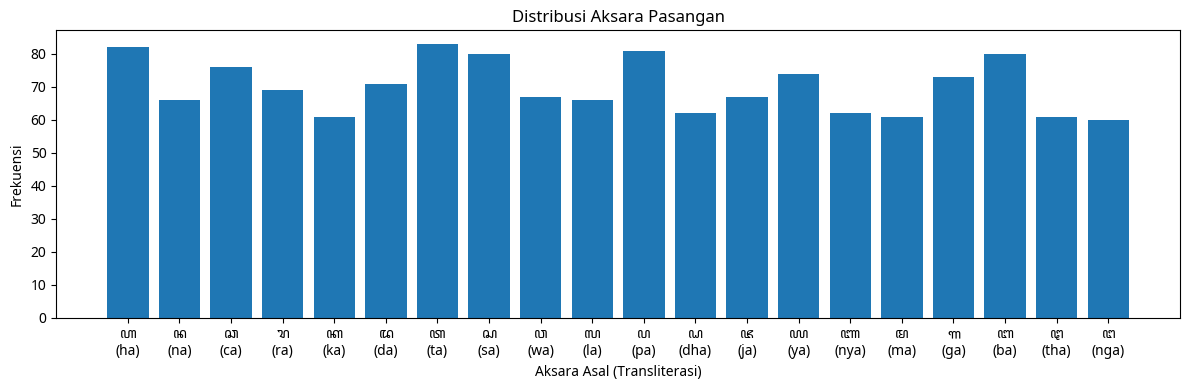

SANDHANGAN SWARA
Total kemunculan : 2286
------------------------------------------------------------
  ꦶ (i ) |     469 |  20.52%
  ꦸ (u ) |     480 |  21.00%
  ꦺ (é ) |     435 |  19.03%
  ꦼ (ê ) |     439 |  19.20%
  ꦴ (o ) |     463 |  20.25%



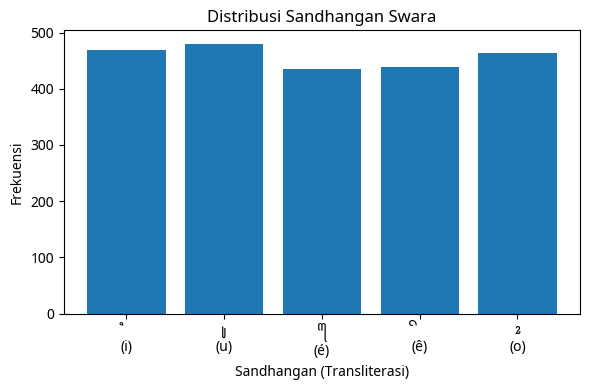

PANYIGEG WANDA (KONSONAN AKHIR)
Total kemunculan : 170
------------------------------------------------------------
  ꦂ (r ) |      55 |  32.35%
  ꦃ (h ) |      64 |  37.65%
  ꦁ (ng) |      51 |  30.00%



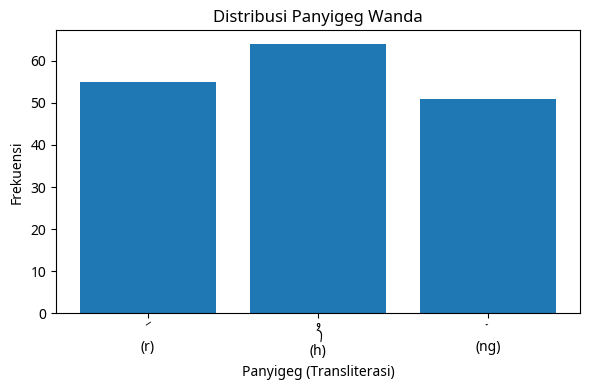

PANGKON (DI AKHIR KATA)
Total kemunculan : 222
------------------------------------------------------------
꧀ (pangkon) |     222 | 100.00%

DISTRIBUSI PANJANG KATA (SUKU KATA)
Total kata : 1000
------------------------------------------------------------
 2 suku |     185 |  18.50%
 3 suku |     174 |  17.40%
 4 suku |     228 |  22.80%
 5 suku |     219 |  21.90%
 6 suku |     194 |  19.40%



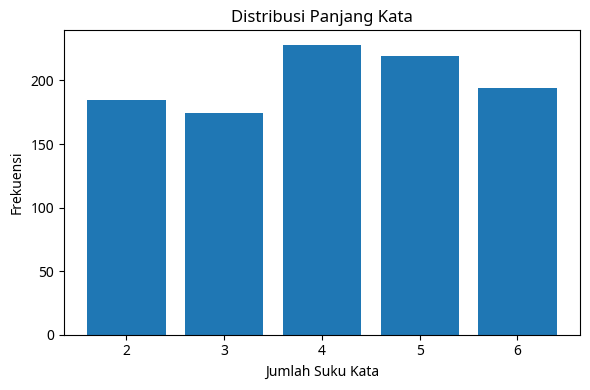

In [5]:
SEP = "=" * 60
SUB = "-" * 60

# =========================
# NGLEGENA
# =========================
print(SEP)
print("NGLEGENA (AKSARA DASAR)")
total = sum(coverage["nglegena"].values())
print(f"Total kemunculan : {total}")
print(SUB)

for aks, lat in NGLEGENA:
    c = coverage["nglegena"].get(aks, 0)
    pct = (c / total * 100) if total else 0
    print(f"{aks:>3} ({lat:<2}) | {c:7d} | {pct:6.2f}%")
print(SEP, "\n")

labels = [f"{aks}\n({lat})" for aks, lat in NGLEGENA]
counts = [coverage["nglegena"].get(aks, 0) for aks, _ in NGLEGENA]

plt.figure(figsize=(12, 4))
plt.bar(labels, counts)
plt.title("Distribusi Aksara Nglegena")
plt.xlabel("Aksara (Transliterasi)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()


# =========================
# PASANGAN
# =========================
print(SEP)
print("PASANGAN (GUGUS KONSONAN)")
total = sum(coverage["pasangan"].values())
print(f"Total kemunculan : {total}")
print(SUB)

for aks, lat in NGLEGENA:
    c = coverage["pasangan"].get(aks, 0)
    if c > 0:
        pct = c / total * 100
        print(f"{aks:>3} ({lat:<2}) | {c:7d} | {pct:6.2f}%")
print(SEP, "\n")

labels = [f"{aks}\n({lat})" for aks, lat in NGLEGENA]
counts = [coverage["pasangan"].get(aks, 0) for aks, _ in NGLEGENA]

plt.figure(figsize=(12, 4))
plt.bar(labels, counts)
plt.title("Distribusi Aksara Pasangan")
plt.xlabel("Aksara Asal (Transliterasi)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()


# =========================
# SANDHANGAN
# =========================
print(SEP)
print("SANDHANGAN SWARA")
total = sum(coverage["sandangan"].values())
print(f"Total kemunculan : {total}")
print(SUB)

for s, lat in SANDANGAN:
    c = coverage["sandangan"].get(s, 0)
    pct = (c / total * 100) if total else 0
    print(f"{s:>3} ({lat:<2}) | {c:7d} | {pct:6.2f}%")
print(SEP, "\n")

labels = [f"{s}\n({lat})" for s, lat in SANDANGAN]
counts = [coverage["sandangan"].get(s, 0) for s, _ in SANDANGAN]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title("Distribusi Sandhangan Swara")
plt.xlabel("Sandhangan (Transliterasi)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()


# =========================
# PANYIGEG
# =========================
print(SEP)
print("PANYIGEG WANDA (KONSONAN AKHIR)")
total = sum(coverage["panyigeg"].values())
print(f"Total kemunculan : {total}")
print(SUB)

for p, lat in PANYIGEG:
    c = coverage["panyigeg"].get(p, 0)
    pct = (c / total * 100) if total else 0
    print(f"{p:>3} ({lat:<2}) | {c:7d} | {pct:6.2f}%")
print(SEP, "\n")

labels = [f"{p}\n({lat})" for p, lat in PANYIGEG]
counts = [coverage["panyigeg"].get(p, 0) for p, _ in PANYIGEG]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title("Distribusi Panyigeg Wanda")
plt.xlabel("Panyigeg (Transliterasi)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()


# =========================
# PANGKON
# =========================
print(SEP)
print("PANGKON (DI AKHIR KATA)")
total = sum(coverage["pangkon"].values())
print(f"Total kemunculan : {total}")
print(SUB)
print(f"꧀ (pangkon) | {total:7d} | 100.00%")
print(SEP, "\n")


# =========================
# PANJANG KATA
# =========================
print(SEP)
print("DISTRIBUSI PANJANG KATA (SUKU KATA)")
total_words = len(df)
print(f"Total kata : {total_words}")
print(SUB)

length_counts = df["length"].value_counts().sort_index()

for i in range(CONFIG["min_word"], CONFIG["max_word"] + 1):
    c = length_counts.get(i, 0)
    pct = (c / total_words * 100) if total_words else 0
    print(f"{i:>2} suku | {c:7d} | {pct:6.2f}%")
print(SEP, "\n")

expected = range(CONFIG["min_word"], CONFIG["max_word"] + 1)
counts = [length_counts.get(i, 0) for i in expected]

plt.figure(figsize=(6, 4))
plt.bar(expected, counts)
plt.title("Distribusi Panjang Kata")
plt.xlabel("Jumlah Suku Kata")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()


NGLEGENA (AKSARA DASAR)
Total kemunculan : 6867
------------------------------------------------------------
  ꦲ (ha) |     367 |   5.34%
  ꦤ (na) |     326 |   4.75%
  ꦕ (ca) |     353 |   5.14%
  ꦫ (ra) |     329 |   4.79%
  ꦏ (ka) |     333 |   4.85%
  ꦢ (da) |     346 |   5.04%
  ꦠ (ta) |     364 |   5.30%
  ꦱ (sa) |     367 |   5.34%
  ꦮ (wa) |     346 |   5.04%
  ꦭ (la) |     345 |   5.02%
  ꦥ (pa) |     378 |   5.50%
  ꦝ (dha) |     341 |   4.97%
  ꦗ (ja) |     327 |   4.76%
  ꦪ (ya) |     364 |   5.30%
  ꦚ (nya) |     323 |   4.70%
  ꦩ (ma) |     300 |   4.37%
  ꦒ (ga) |     338 |   4.92%
  ꦧ (ba) |     388 |   5.65%
  ꦛ (tha) |     311 |   4.53%
  ꦔ (nga) |     321 |   4.67%



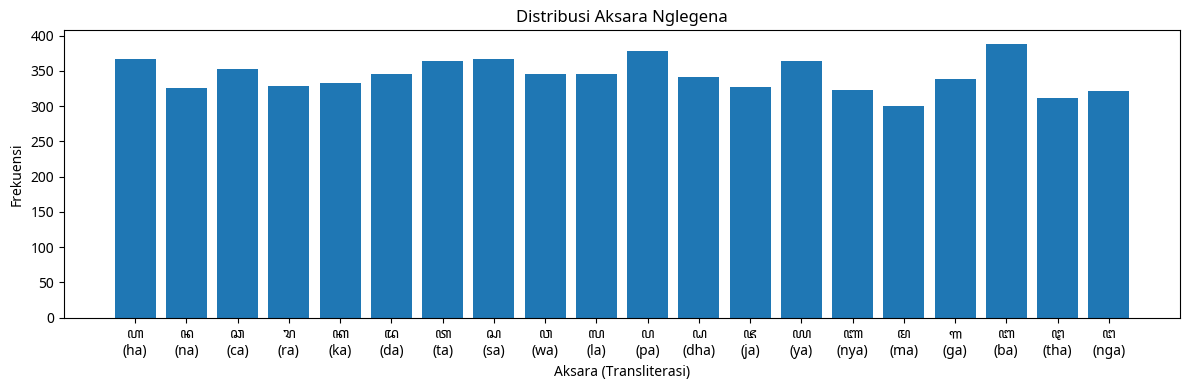

PASANGAN (GUGUS KONSONAN)
Total kemunculan : 1402
------------------------------------------------------------
 ꦲ (ha) |      82 |   5.85%
 ꦤ (na) |      66 |   4.71%
 ꦕ (ca) |      76 |   5.42%
 ꦫ (ra) |      69 |   4.92%
 ꦏ (ka) |      61 |   4.35%
 ꦢ (da) |      71 |   5.06%
 ꦠ (ta) |      83 |   5.92%
 ꦱ (sa) |      80 |   5.71%
 ꦮ (wa) |      67 |   4.78%
 ꦭ (la) |      66 |   4.71%
 ꦥ (pa) |      81 |   5.78%
 ꦝ (dha) |      62 |   4.42%
 ꦗ (ja) |      67 |   4.78%
 ꦪ (ya) |      74 |   5.28%
 ꦚ (nya) |      62 |   4.42%
 ꦩ (ma) |      61 |   4.35%
 ꦒ (ga) |      73 |   5.21%
 ꦧ (ba) |      80 |   5.71%
 ꦛ (tha) |      61 |   4.35%
 ꦔ (nga) |      60 |   4.28%



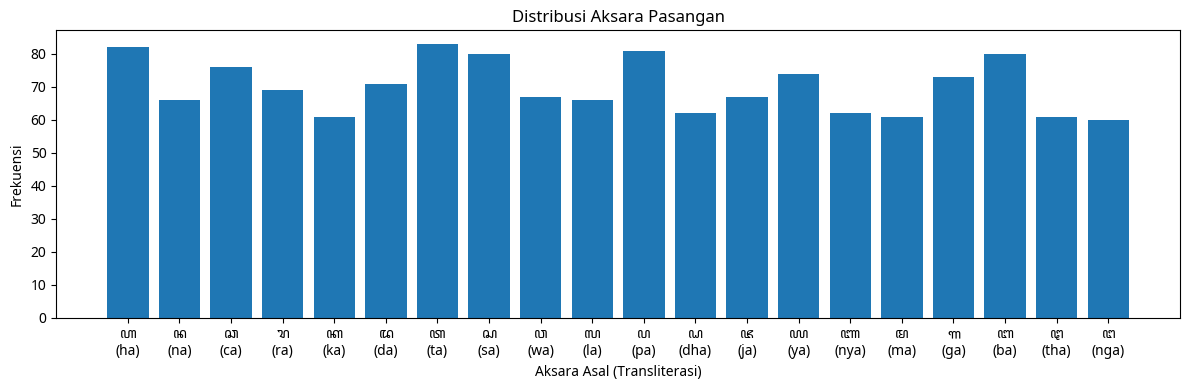

SANDHANGAN SWARA
Total kemunculan : 2286
------------------------------------------------------------
  ꦶ (i ) |     469 |  20.52%
  ꦸ (u ) |     480 |  21.00%
  ꦺ (é ) |     435 |  19.03%
  ꦼ (ê ) |     439 |  19.20%
  ꦴ (o ) |     463 |  20.25%



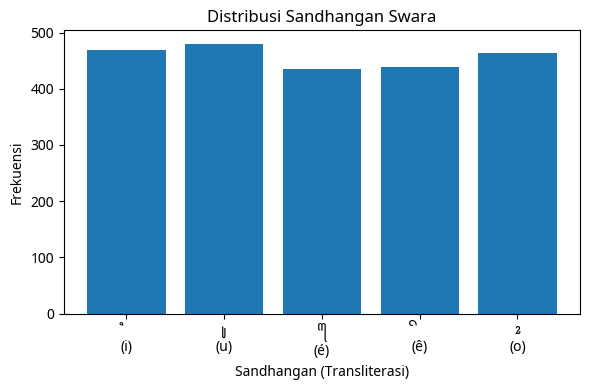

PANYIGEG WANDA (KONSONAN AKHIR)
Total kemunculan : 170
------------------------------------------------------------
  ꦂ (r ) |      55 |  32.35%
  ꦃ (h ) |      64 |  37.65%
  ꦁ (ng) |      51 |  30.00%



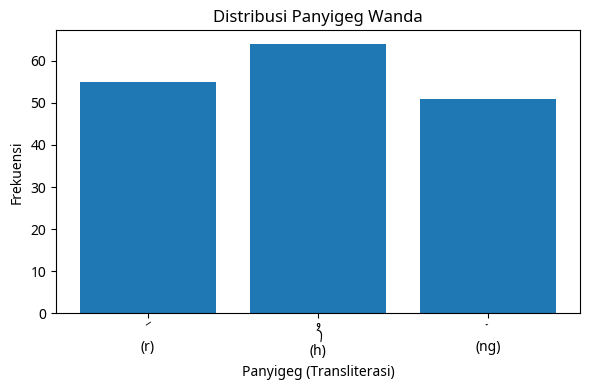

PANGKON (DI AKHIR KATA)
Total kemunculan : 1624
------------------------------------------------------------
꧀ (pangkon) |    1624 | 100.00%

DISTRIBUSI PANJANG KATA (SUKU KATA)
Total kata : 1000
------------------------------------------------------------
 2 suku |     185 |  18.50%
 3 suku |     174 |  17.40%
 4 suku |     228 |  22.80%
 5 suku |     219 |  21.90%
 6 suku |     194 |  19.40%



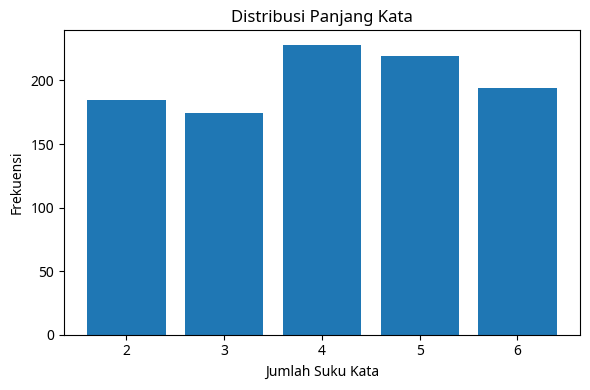

In [6]:
df = pd.read_csv(CSV_PATH)

SEP = "=" * 60
SUB = "-" * 60

# =========================
# Hitung kemunculan aksara
# =========================
# Flatten semua karakter di kolom transcription
all_chars = "".join(df["transcription"].astype(str))
counter_all = Counter(all_chars)

# =========================
# NGLEGENA
# =========================
print(SEP)
print("NGLEGENA (AKSARA DASAR)")
total = sum(counter_all[aks] for aks, _ in NGLEGENA)
print(f"Total kemunculan : {total}")
print(SUB)

for aks, lat in NGLEGENA:
    c = counter_all.get(aks, 0)
    pct = (c / total * 100) if total else 0
    print(f"{aks:>3} ({lat:<2}) | {c:7d} | {pct:6.2f}%")
print(SEP, "\n")

labels = [f"{aks}\n({lat})" for aks, lat in NGLEGENA]
counts = [counter_all.get(aks, 0) for aks, _ in NGLEGENA]

plt.figure(figsize=(12, 4))
plt.bar(labels, counts)
plt.title("Distribusi Aksara Nglegena")
plt.xlabel("Aksara (Transliterasi)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

# =========================
# PASANGAN
# =========================
print(SEP)
print("PASANGAN (GUGUS KONSONAN)")
counter_pasangan = Counter()
for word in df["transcription"]:
    for aks, _ in NGLEGENA:
        pasangan = "꧀" + aks
        counter_pasangan[aks] += word.count(pasangan)

total = sum(counter_pasangan.values())
print(f"Total kemunculan : {total}")
print(SUB)

for aks, lat in NGLEGENA:
    c = counter_pasangan.get(aks, 0)
    if c > 0:
        pct = c / total * 100
        print(f"{aks:>2} ({lat:<2}) | {c:7d} | {pct:6.2f}%")
print(SEP, "\n")

labels = [f"{aks}\n({lat})" for aks, lat in NGLEGENA]
counts = [counter_pasangan.get(aks, 0) for aks, _ in NGLEGENA]

plt.figure(figsize=(12, 4))
plt.bar(labels, counts)
plt.title("Distribusi Aksara Pasangan")
plt.xlabel("Aksara Asal (Transliterasi)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

# =========================
# SANDHANGAN
# =========================
print(SEP)
print("SANDHANGAN SWARA")
total = sum(counter_all[s] for s, _ in SANDANGAN)
print(f"Total kemunculan : {total}")
print(SUB)

for s, lat in SANDANGAN:
    c = counter_all.get(s, 0)
    pct = (c / total * 100) if total else 0
    print(f"{s:>3} ({lat:<2}) | {c:7d} | {pct:6.2f}%")
print(SEP, "\n")

labels = [f"{s}\n({lat})" for s, lat in SANDANGAN]
counts = [counter_all.get(s, 0) for s, _ in SANDANGAN]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title("Distribusi Sandhangan Swara")
plt.xlabel("Sandhangan (Transliterasi)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

# =========================
# PANYIGEG
# =========================
print(SEP)
print("PANYIGEG WANDA (KONSONAN AKHIR)")
total = sum(counter_all[p] for p, _ in PANYIGEG)
print(f"Total kemunculan : {total}")
print(SUB)

for p, lat in PANYIGEG:
    c = counter_all.get(p, 0)
    pct = (c / total * 100) if total else 0
    print(f"{p:>3} ({lat:<2}) | {c:7d} | {pct:6.2f}%")
print(SEP, "\n")

labels = [f"{p}\n({lat})" for p, lat in PANYIGEG]
counts = [counter_all.get(p, 0) for p, _ in PANYIGEG]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title("Distribusi Panyigeg Wanda")
plt.xlabel("Panyigeg (Transliterasi)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

# =========================
# PANGKON
# =========================
print(SEP)
print("PANGKON (DI AKHIR KATA)")
total = counter_all.get(PANGKON[0], 0)
print(f"Total kemunculan : {total}")
print(SUB)
print(f"{PANGKON[0]} (pangkon) | {total:7d} | 100.00%")
print(SEP, "\n")

# =========================
# PANJANG KATA
# =========================
print(SEP)
print("DISTRIBUSI PANJANG KATA (SUKU KATA)")
total_words = len(df)
print(f"Total kata : {total_words}")
print(SUB)

length_counts = df["length"].value_counts().sort_index()

for i in range(CONFIG["min_word"], CONFIG["max_word"] + 1):
    c = length_counts.get(i, 0)
    pct = (c / total_words * 100) if total_words else 0
    print(f"{i:>2} suku | {c:7d} | {pct:6.2f}%")
print(SEP, "\n")

expected = range(CONFIG["min_word"], CONFIG["max_word"] + 1)
counts = [length_counts.get(i, 0) for i in expected]

plt.figure(figsize=(6, 4))
plt.bar(expected, counts)
plt.title("Distribusi Panjang Kata")
plt.xlabel("Jumlah Suku Kata")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

=== Summary Pelanggaran Ortografi ===
    jenis_pelanggaran  count
0  PANYIGEG_DI_TENGAH     38
Total kata yang melanggar: 38



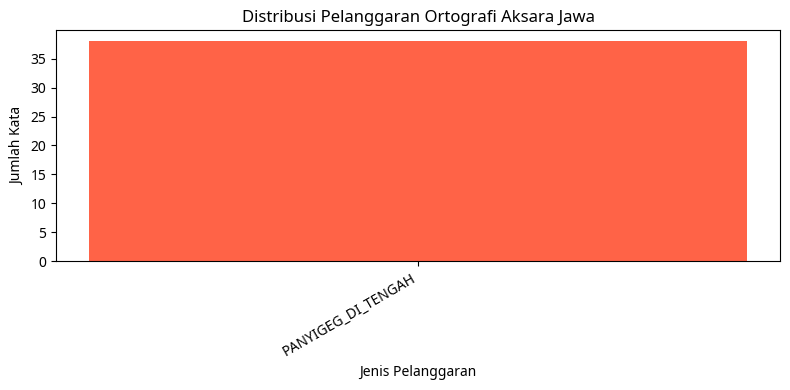

,index,kata,jenis_pelanggaran,detail
0,1,ꦗꦼꦭꦏꦼꦪꦺꦔ꧀ꦪꦪꦃ꧀,PANYIGEG_DI_TENGAH,Panyigeg 'ꦃ' diikuti pasangan
1,11,ꦚꦼꦠꦴꦂ꧀,PANYIGEG_DI_TENGAH,Panyigeg 'ꦂ' diikuti pasangan
2,17,ꦔꦼꦝꦠꦴꦂ꧀,PANYIGEG_DI_TENGAH,Panyigeg 'ꦂ' diikuti pasangan
3,85,ꦪꦺꦫꦔꦩꦼꦃ꧀,PANYIGEG_DI_TENGAH,Panyigeg 'ꦃ' diikuti pasangan
4,121,ꦔꦸꦪꦸ꧀ꦥꦥꦂ꧀,PANYIGEG_DI_TENGAH,Panyigeg 'ꦂ' diikuti pasangan
5,135,ꦚ꧀ꦥꦥꦧꦴꦗꦴ꧀ꦝꦝꦁ꧀,PANYIGEG_DI_TENGAH,Panyigeg 'ꦁ' diikuti pasangan
6,169,ꦏ꧀ꦔꦔꦮ꧀ꦩꦩꦥꦼꦧꦺ꧀ꦏꦏꦩꦺꦤꦁ꧀,PANYIGEG_DI_TENGAH,Panyigeg 'ꦁ' diikuti pasangan
7,188,ꦱꦺ꧀ꦝꦝꦮꦼꦁ꧀,PANYIGEG_DI_TENGAH,Panyigeg 'ꦁ' diikuti pasangan
8,233,ꦚꦴꦤ꧀ꦫꦫꦃ꧀,PANYIGEG_DI_TENGAH,Panyigeg 'ꦃ' diikuti pasangan
9,259,ꦝꦴꦗꦴ꧀ꦠꦠꦗꦸꦁ꧀,PANYIGEG_DI_TENGAH,Panyigeg 'ꦁ' diikuti pasangan


In [7]:
def check_orthography(df):
    """
    Mengecek aturan penulisan Aksara Jawa dari dataframe CSV.
    
    Aturan yang dicek:
    1. Pasangan ('꧀' + aksara) tidak boleh di awal kata.
    2. Pangkon ('꧀') hanya boleh di akhir kata, tidak boleh di tengah.
    3. Sandhangan swara:
        - Tidak boleh menumpuk dua sandhangan swara pada satu aksara.
        - Tidak boleh muncul setelah aksara mati (pangkon atau pasangan).
    4. Panyigeg ('ꦁ', 'ꦃ', 'ꦂ'):
        - Hanya boleh di akhir suku kata.
        - Tidak boleh diikuti pasangan.
    5. Urutan suku kata: [Konsonan hidup] + [Sandhangan?] + [Pasangan?] + [Panyigeg?]
    """
    violations = []

    for idx, row in df.iterrows():
        word = row["transcription"]

        # 1. Pasangan di awal kata
        if word.startswith("꧀"):
            violations.append((idx, word, "PASANGAN_AWAL", "Kata diawali pasangan"))

        # 2. Pangkon di tengah kata (pangkon yang bukan bagian pasangan)
        for i, ch in enumerate(word):
            if ch == "꧀":
                # Cek apakah pangkon ini bagian dari pasangan (ikuti karakter setelahnya)
                if i + 1 < len(word) and word[i+1] in [aks for aks, _ in NGLEGENA]:
                    continue  # ini pasangan, bukan pangkon bebas
                # Jika pangkon di tengah kata, catat pelanggaran
                if i < len(word) - 1:
                    violations.append((idx, word, "PANGKON_TENGAH", "Pangkon bebas muncul di tengah kata"))

        # 3. Sandhangan menumpuk atau setelah aksara mati
        # Membuat list karakter pangkon + pasangan untuk cek sandhangan
        for i, ch in enumerate(word):
            # Jika ada sandhangan, cek sebelumnya
            if ch in [s[0] for s in SANDANGAN]:
                if i > 0 and word[i-1] == "꧀":  # muncul setelah pangkon
                    violations.append((idx, word, "SANDHANGAN_SETELAH_PANGKON", f"Sandhangan '{ch}' muncul setelah pangkon"))
                if i > 1 and word[i-2:i] in [PASANGAN[aks] for aks, _ in NGLEGENA]:  # muncul setelah pasangan
                    violations.append((idx, word, "SANDHANGAN_SETELAH_PASANGAN", f"Sandhangan '{ch}' muncul setelah pasangan"))
                # cek sandhangan bertumpuk
                if i+1 < len(word) and word[i+1] in [s[0] for s in SANDANGAN]:
                    violations.append((idx, word, "SANDHANGAN_TUMPUK", f"Sandhangan '{ch}' bertumpuk dengan '{word[i+1]}'"))

        # 4. Panyigeg diikuti pasangan
        for p, _ in PANYIGEG:
            idx_p = word.find(p)
            while idx_p != -1:
                if idx_p+1 < len(word) and word[idx_p+1] == "꧀":
                    violations.append((idx, word, "PANYIGEG_DI_TENGAH", f"Panyigeg '{p}' diikuti pasangan"))
                idx_p = word.find(p, idx_p+1)

        # 5. Pangkon di akhir kata valid (opsional cek, boleh skip)
        if word.endswith("꧀") and len(word) == 1:
            violations.append((idx, word, "PANGKON_SAJA", "Kata hanya pangkon"))

    return pd.DataFrame(violations, columns=["index", "kata", "jenis_pelanggaran", "detail"])


def summarize_violations(violations_df):
    """
    Membuat ringkasan jumlah pelanggaran per kategori
    dan visualisasi batang.
    """
    summary = violations_df.groupby("jenis_pelanggaran").size().reset_index(name="count")
    print("=== Summary Pelanggaran Ortografi ===")
    print(summary)
    print(f"Total kata yang melanggar: {violations_df['index'].nunique()}\n")

    # Plot distribusi
    plt.figure(figsize=(8, 4))
    plt.bar(summary["jenis_pelanggaran"], summary["count"], color="tomato")
    plt.title("Distribusi Pelanggaran Ortografi Aksara Jawa")
    plt.xlabel("Jenis Pelanggaran")
    plt.ylabel("Jumlah Kata")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


violations_df = check_orthography(df)
summarize_violations(violations_df)
violations_df.head(10)